In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import category_encoders as ce 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from datetime import datetime
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [2]:
train = pickle.load(open('c_train.pickle', 'rb'))
b = pickle.load(open('c_b.pickle', 'rb'))
bb = pickle.load(open('c_bb.pickle', 'rb'))
ccb = pickle.load(open('c_cb.pickle', 'rb'))
ip = pickle.load(open('c_ip.pickle', 'rb'))
pcb = pickle.load(open('c_pcb.pickle', 'rb'))
pa = pickle.load(open('c_pa.pickle', 'rb'))
test = pickle.load(open('c_test.pickle', 'rb'))

In [3]:
train.isnull().sum()


SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 81, dtype: int64

In [4]:
b.isnull().sum()

SK_ID_CURR                0
CREDIT_ACTIVE             0
CREDIT_TYPE               0
CNT_CREDIT_PROLONG        0
CREDIT_DAY_OVERDUE        0
AMT_CREDIT_MAX_OVERDUE    0
AMT_CREDIT_SUM            0
AMT_CREDIT_SUM_DEBT       0
AMT_CREDIT_SUM_LIMIT      0
AMT_CREDIT_SUM_OVERDUE    0
dtype: int64

In [5]:
bb.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [6]:
ccb.isnull().sum()

SK_ID_CURR                   0
AMT_BALANCE                  0
AMT_CREDIT_LIMIT_ACTUAL      0
AMT_RECEIVABLE_PRINCIPAL     0
AMT_RECIVABLE                0
AMT_TOTAL_RECEIVABLE         0
CNT_INSTALMENT_MATURE_CUM    0
dtype: int64

In [7]:
ip.isnull().sum()

DAYS_ENTRY_PAYMENT    0
AMT_INSTALMENT        0
AMT_PAYMENT           0
dtype: int64

In [8]:
pcb.isnull().sum()

SK_ID_CURR               0
NAME_CONTRACT_STATUS     0
CNT_INSTALMENT           0
CNT_INSTALMENT_FUTURE    0
dtype: int64

In [9]:
pa.isnull().sum()

SK_ID_CURR             0
AMT_DOWN_PAYMENT       0
CODE_REJECT_REASON     0
NAME_YIELD_GROUP       0
PRODUCT_COMBINATION    0
AMT_APPLICATION        0
AMT_CREDIT             0
CNT_PAYMENT            0
dtype: int64

# Train

In [10]:
# train = train[[
#     'SK_ID_CURR',
#     'TARGET',
#     'NAME_CONTRACT_TYPE',
#     'CODE_GENDER',
#     'FLAG_OWN_REALTY',
#     'NAME_INCOME_TYPE',
#     'EXT_SOURCE_2',
#     'EXT_SOURCE_3',
#     'DAYS_BIRTH',
#     'REGION_RATING_CLIENT_W_CITY',
#     'DAYS_LAST_PHONE_CHANGE',
#     'DAYS_ID_PUBLISH',
#     'REG_CITY_NOT_WORK_CITY',
    

    
#     #DROP BELOW
#     'AMT_INCOME_TOTAL',

#     #FEAT ENGINEERING
#    'REGION_POPULATION_RELATIVE',
#    'AMT_ANNUITY'
# ]]
# train

## Merging

### Credit Card Balance with Train

In [11]:
train = train.merge(ccb, how='left', on='SK_ID_CURR')
train.shape

(307511, 87)

### POS Cash Balance with Train

In [12]:
train = train.merge(pcb, how='left', on='SK_ID_CURR')
train.shape

(307511, 90)

### Bureau with Bureau Balance

In [13]:
# b = b.merge(bb, how='left', on='SK_ID_BUREAU')


### Bureau with Train

In [14]:
train = train.merge(b, how='left', on='SK_ID_CURR')
train.shape

(307511, 99)

### Previous Application with Train

In [15]:
train = train.merge(pa, how='left', on='SK_ID_CURR')
train.shape

(307511, 106)

In [16]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY,...,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_DOWN_PAYMENT,CODE_REJECT_REASON,NAME_YIELD_GROUP,PRODUCT_COMBINATION,AMT_APPLICATION,AMT_CREDIT_y,CNT_PAYMENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,75876.536759,6397.713,0.0,0.000000,XAP,low_normal,POS other with interest,179055.000,179055.00,12.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.000000,202500.000,0.0,2295.000000,XAP,middle,Cash X-Sell: low,435436.500,484191.00,20.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.000000,0.000,0.0,4860.000000,XAP,middle,POS mobile without interest,24282.000,20106.00,12.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,8466.887198,XAP,XNA,Cash,272203.260,291695.50,22.666667
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.000000,0.000,0.0,1130.250000,XAP,high,Cash X-Sell: middle,150530.250,166638.75,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,0.000000,XAP,high,POS mobile with interest,40455.000,40455.00,12.000000
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,3456.000000,XAP,low_normal,POS household without interest,57595.500,56821.50,12.000000
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,448958.250000,0.000,0.0,4403.250000,XAP,high,POS mobile with interest,24162.750,20625.75,12.000000
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.000000,0.000,0.0,0.000000,XAP,high,POS household with interest,121317.750,134439.75,12.000000


## Feature Engineering

In [17]:
sorted_columns = sorted(train.columns)
for column in sorted_columns:
    print(column)

AMT_ANNUITY
AMT_APPLICATION
AMT_BALANCE
AMT_CREDIT_LIMIT_ACTUAL
AMT_CREDIT_MAX_OVERDUE
AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT
AMT_CREDIT_SUM_LIMIT
AMT_CREDIT_SUM_OVERDUE
AMT_CREDIT_x
AMT_CREDIT_y
AMT_DOWN_PAYMENT
AMT_GOODS_PRICE
AMT_INCOME_TOTAL
AMT_RECEIVABLE_PRINCIPAL
AMT_RECIVABLE
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_MON
AMT_REQ_CREDIT_BUREAU_QRT
AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_YEAR
AMT_TOTAL_RECEIVABLE
CNT_CHILDREN
CNT_CREDIT_PROLONG
CNT_FAM_MEMBERS
CNT_INSTALMENT
CNT_INSTALMENT_FUTURE
CNT_INSTALMENT_MATURE_CUM
CNT_PAYMENT
CODE_GENDER
CODE_REJECT_REASON
CREDIT_ACTIVE
CREDIT_DAY_OVERDUE
CREDIT_TYPE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_ID_PUBLISH
DAYS_LAST_PHONE_CHANGE
DAYS_REGISTRATION
DEF_30_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
EMERGENCYSTATE_MODE
EXT_SOURCE_2
EXT_SOURCE_3
FLAG_CONT_MOBILE
FLAG_DOCUMENT_10
FLAG_DOCUMENT_11
FLAG_DOCUMENT_12
FLAG_DOCUMENT_13
FLAG_DOCUMENT_14
FLAG_DOCUMENT_15
FLAG_DOCUMENT_16
FLAG_DOCUMENT_17
FLAG_DOCU

### Debt to Income Ratio

In [18]:
train['DTI'] = train['AMT_CREDIT_SUM_DEBT']/train['AMT_INCOME_TOTAL']
train['DTI'] = train['DTI'].round(2)

### Age

In [19]:
train['AGE'] = (train['DAYS_BIRTH']//365).abs()

### Debt Credit Ratio

In [20]:
train['DEBT_CREDIT_RATIO'] = train['AMT_CREDIT_SUM_DEBT']/train['AMT_CREDIT_SUM']
train['DEBT_CREDIT_RATIO'] = train['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], 0, inplace=True)
train['DEBT_CREDIT_RATIO'].value_counts()

C:\Users\rvuon\AppData\Local\Temp\ipykernel_30656\2643135572.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['DEBT_CREDIT_RATIO'] = train['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], 0, inplace=True)


Series([], Name: count, dtype: int64)

### Credit Annuity Ratio

In [21]:
train['CREDIT_ANNUITY_RATIO'] = train['AMT_CREDIT_x']/train['AMT_ANNUITY']
train['CREDIT_ANNUITY_RATIO'].value_counts()

CREDIT_ANNUITY_RATIO
20.000000    29242
34.199726     1985
34.083333     1643
30.844490     1448
34.063122     1263
             ...  
10.598461        1
30.776590        1
29.744200        1
25.216053        1
17.908934        1
Name: count, Length: 39550, dtype: int64

## Correlation

In [22]:
print(train.select_dtypes(include=['object', 'category']).columns)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'EMERGENCYSTATE_MODE', 'NAME_CONTRACT_STATUS', 'CREDIT_ACTIVE',
       'CREDIT_TYPE', 'CODE_REJECT_REASON', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'DEBT_CREDIT_RATIO'],
      dtype='object')


In [23]:
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
train.corr(numeric_only=True)['TARGET'].abs().sort_values(ascending=False)

TARGET                          1.000000
EXT_SOURCE_2                    0.160303
EXT_SOURCE_3                    0.157397
AMT_BALANCE                     0.087177
AMT_TOTAL_RECEIVABLE            0.086490
AMT_RECIVABLE                   0.086478
AMT_RECEIVABLE_PRINCIPAL        0.086062
DAYS_BIRTH                      0.078239
AGE                             0.078237
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
DAYS_LAST_PHONE_CHANGE          0.055217
DAYS_ID_PUBLISH                 0.051457
REG_CITY_NOT_WORK_CITY          0.050994
FLAG_EMP_PHONE                  0.045982
DAYS_EMPLOYED                   0.044932
REG_CITY_NOT_LIVE_CITY          0.044395
FLAG_DOCUMENT_3                 0.044346
DAYS_REGISTRATION               0.041975
CNT_INSTALMENT_MATURE_CUM       0.040054
AMT_GOODS_PRICE                 0.039628
FLOORSMAX_MODE                  0.038377
REGION_POPULATION_RELATIVE      0.037227
LIVE_CITY_NOT_WORK_CITY         0.032518
DEF_30_CNT_SOCIA

In [24]:
train.corr(numeric_only=True)[(train.corr(numeric_only=True) >= 0.7) | (train.corr(numeric_only=True) <= -0.7)]

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,CNT_CREDIT_PROLONG,CREDIT_DAY_OVERDUE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_CREDIT_y,CNT_PAYMENT,DTI,AGE,CREDIT_ANNUITY_RATIO
SK_ID_CURR,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TARGET,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.87916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_INCOME_TOTAL,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_CREDIT_x,NaN,NaN,NaN,NaN,1.000000,0.770127,0.986588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_ANNUITY,NaN,NaN,NaN,NaN,0.770127,1.000000,0.774661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,0.986588,0.774661,1.000000,N

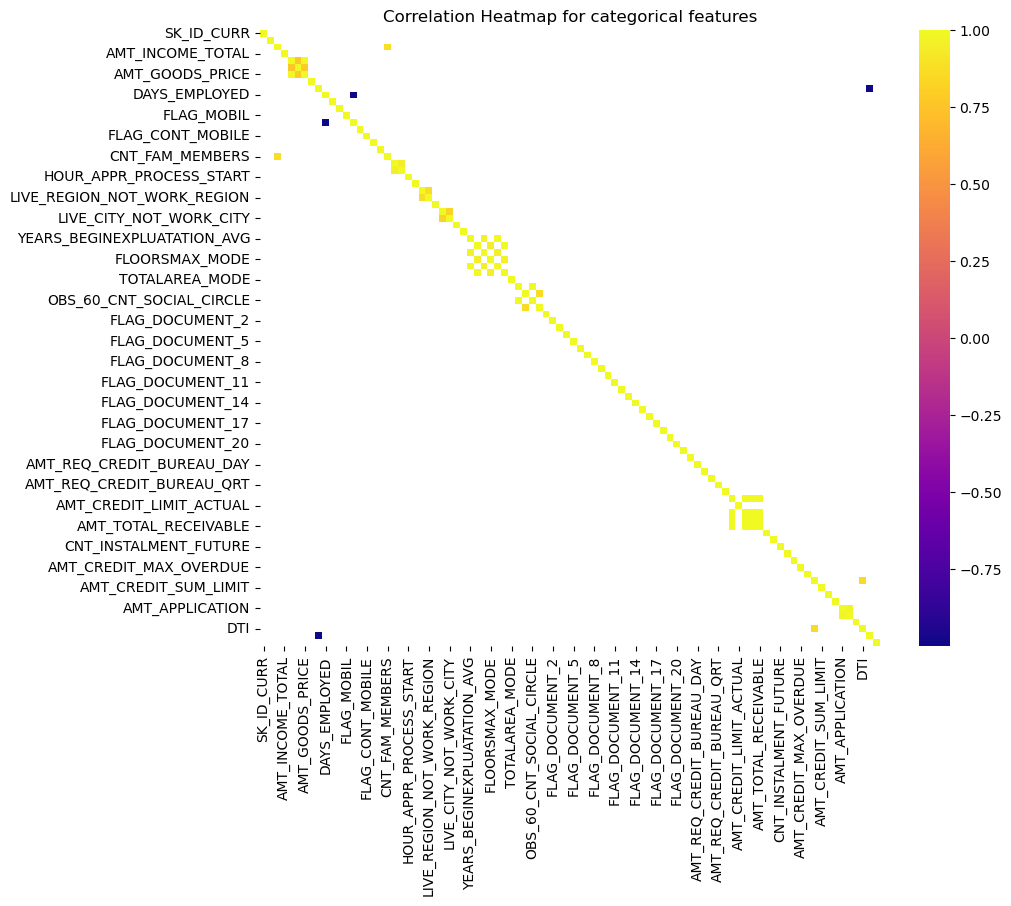

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap((train.corr(numeric_only=True)[(train.corr(numeric_only=True) >= 0.7) | (train.corr(numeric_only=True) <= -0.7)]), cmap='plasma', annot=False, annot_kws={'size': 2, 'color':'black'})
plt.title('Correlation Heatmap for categorical features')
plt.show()

In [25]:
# train = train[[
#     #TRAIN
#     'SK_ID_CURR',
#     'TARGET',
#     'NAME_CONTRACT_TYPE',
#     'CODE_GENDER',
#     'FLAG_OWN_REALTY',
#     'NAME_INCOME_TYPE',
#     'EXT_SOURCE_2',
#     'EXT_SOURCE_3',
#     # 'DAYS_BIRTH',
#     'REGION_RATING_CLIENT_W_CITY',
#     'DAYS_LAST_PHONE_CHANGE',
#     'DAYS_ID_PUBLISH',
#     'REG_CITY_NOT_WORK_CITY',
    
    
#     #CREDIT CARD BALANCE
#     'AMT_BALANCE',
#     # 'AMT_CREDIT_LIMIT_ACTUAL',
#     # 'AMT_RECEIVABLE_PRINCIPAL',
#     # 'AMT_RECIVABLE',
#     'AMT_TOTAL_RECEIVABLE',
#     'CNT_INSTALMENT_MATURE_CUM',

#     #POS CASH BALANCE
#     'NAME_CONTRACT_STATUS',
#     'CNT_INSTALMENT',
#     'CNT_INSTALMENT_FUTURE',
    
#     #BUREAU
#     'CREDIT_ACTIVE',
#     'CREDIT_TYPE',
#     'CNT_CREDIT_PROLONG',
#     'CREDIT_DAY_OVERDUE',
#     'AMT_CREDIT_MAX_OVERDUE',
#     # 'AMT_CREDIT_SUM',
#     # 'AMT_CREDIT_SUM_DEBT',
#     'AMT_CREDIT_SUM_LIMIT',
#     'AMT_CREDIT_SUM_OVERDUE',

#     #PREVIOUS APPLICATION
#     'AMT_DOWN_PAYMENT',
#     'CODE_REJECT_REASON',
#     'NAME_YIELD_GROUP',
#     'PRODUCT_COMBINATION',
#     'AMT_APPLICATION',
#     # 'AMT_CREDIT',
#     'CNT_PAYMENT',

#     #ADDED FEATS
#     'REGION_POPULATION_RELATIVE',

#     #FEAT USED TO ENGINEER
#     'AMT_ANNUITY',

#     #FEAT ENGINEERING
#     'DTI',
#     'AGE',
#     'DEBT_CREDIT_RATIO',
#     'CREDIT_ANNUITY_RATIO'
# ]]
# train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_REALTY              307511 non-null  object 
 5   NAME_INCOME_TYPE             307511 non-null  object 
 6   EXT_SOURCE_2                 307511 non-null  float64
 7   EXT_SOURCE_3                 307511 non-null  float64
 8   REGION_RATING_CLIENT_W_CITY  307511 non-null  int64  
 9   DAYS_LAST_PHONE_CHANGE       307511 non-null  float64
 10  DAYS_ID_PUBLISH              307511 non-null  int64  
 11  REG_CITY_NOT_WORK_CITY       307511 non-null  int64  
 12  AMT_BALANCE                  86905 non-null   float64
 13 

In [ ]:
train = train[[
    'SK_ID_CURR',
    'TARGET',

    #CATEGORICAL
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE',
    'EMERGENCYSTATE_MODE',
    'NAME_CONTRACT_STATUS',
    'CREDIT_ACTIVE',
    'CREDIT_TYPE',
    'CODE_REJECT_REASON',
    'NAME_YIELD_GROUP',
    'PRODUCT_COMBINATION',
    'DEBT_CREDIT_RATIO',

    #CONTINUOUS
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'AMT_BALANCE',
    'AMT_TOTAL_RECEIVABLE',
    'AMT_RECIVABLE',
    'AMT_RECEIVABLE_PRINCIPAL',
    'DAYS_BIRTH',
    'REGION_RATING_CLIENT_W_CITY',
    'REGION_RATING_CLIENT',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_ID_PUBLISH',
    'REG_CITY_NOT_WORK_CITY',
    'FLAG_EMP_PHONE',
    'DAYS_EMPLOYED',
    'REG_CITY_NOT_LIVE_CITY',
    'FLAG_DOCUMENT_3',
    'DAYS_REGISTRATION',
    'CNT_INSTALMENT_MATURE_CUM',
    'AMT_GOODS_PRICE',
    'FLOORSMAX_MODE',
    'REGION_POPULATION_RELATIVE',
    'LIVE_CITY_NOT_WORK_CITY',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'CREDIT_ANNUITY_RATIO',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_CREDIT_x',
    'TOTALAREA_MODE',
    'FLOORSMAX_AVG',
    'FLOORSMAX_MEDI',
    'FLAG_DOCUMENT_6',
    'FLAG_WORK_PHONE',
    'AMT_DOWN_PAYMENT',
    'HOUR_APPR_PROCESS_START',
    'FLAG_PHONE',
    'AMT_APPLICATION',
    'AMT_CREDIT_SUM',
    'CNT_CHILDREN',
    'AMT_CREDIT_y',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_ANNUITY',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_13',
    'AMT_CREDIT_SUM_LIMIT'

    #FEAT ENGINEERED
    'AGE',
    'DTI',
    'DEBT_CREDIT_RATIO',
    'CREDIT_ANNUITY_RATIO'
]]

## Encoding/Scaling

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_REALTY              307511 non-null  object 
 5   NAME_INCOME_TYPE             307511 non-null  object 
 6   EXT_SOURCE_2                 307511 non-null  float64
 7   EXT_SOURCE_3                 307511 non-null  float64
 8   REGION_RATING_CLIENT_W_CITY  307511 non-null  int64  
 9   DAYS_LAST_PHONE_CHANGE       307511 non-null  float64
 10  DAYS_ID_PUBLISH              307511 non-null  int64  
 11  REG_CITY_NOT_WORK_CITY       307511 non-null  int64  
 12  AMT_BALANCE                  86905 non-null   float64
 13 

In [28]:
ord_feats_edit = [
    'FLAG_OWN_REALTY',
    'EXT_SOURCE_2',#
    'EXT_SOURCE_3',
    'AGE',
    'REGION_RATING_CLIENT_W_CITY',
    'CREDIT_DAY_OVERDUE',#
    'AMT_CREDIT_SUM_OVERDUE',#
    'NAME_YIELD_GROUP',
    'DTI'

    # 'FLAG_OWN_REALTY',
    # 'REGION_RATING_CLIENT_W_CITY',
    # 'AMT_CREDIT_LIMIT_ACTUAL',
    # 'NAME_YIELD_GROUP',
    # 'PRODUCT_COMBINATION'
]

ord_feats = train[ord_feats_edit]
ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ord.fit(ord_feats)
ord_feats_encoded = ord.transform(ord_feats)
new_ord_feats = pd.DataFrame(ord_feats_encoded, columns=ord_feats.columns)
new_ord_feats




,FLAG_OWN_REALTY,EXT_SOURCE_2,EXT_SOURCE_3,AGE,REGION_RATING_CLIENT_W_CITY,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,NAME_YIELD_GROUP,DTI
0,1.0,28075.0,287.0,5.0,1.0,0.0,0.0,3.0,69.0
1,0.0,85082.0,546.0,25.0,0.0,0.0,0.0,4.0,32.0
2,1.0,72834.0,678.0,32.0,1.0,0.0,0.0,4.0,32.0
3,1.0,90562.0,546.0,32.0,1.0,NaN,NaN,0.0,NaN
4,1.0,36023.0,546.0,34.0,1.0,0.0,0.0,1.0,32.0
...,...,...,...,...,...,...,...,...,...
307506,0.0,96859.0,546.0,5.0,0.0,NaN,NaN,1.0,NaN
307507,1.0,11578.0,546.0,36.0,1.0,NaN,NaN,3.0,NaN
307508,1.0,69250.0,363.0,21.0,2.0,0.0,0.0,1.0,325.0
307509,1.0,65504.0,633.0,12.0,1.0,0.0,0.0,1.0,32.0


In [29]:
train.drop(columns=ord_feats, inplace=True)
train = train.merge(new_ord_feats, left_index=True, right_index=True)
train

C:\Users\rvuon\AppData\Local\Temp\ipykernel_10772\3098617036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=ord_feats, inplace=True)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_INCOME_TYPE,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,CREDIT_ACTIVE,CREDIT_TYPE,CNT_CREDIT_PROLONG,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_DOWN_PAYMENT,CODE_REJECT_REASON,PRODUCT_COMBINATION,AMT_APPLICATION,CNT_PAYMENT,REGION_POPULATION_RELATIVE,AMT_ANNUITY,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,FLAG_OWN_REALTY,EXT_SOURCE_2,EXT_SOURCE_3,AGE,REGION_RATING_CLIENT_W_CITY,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,NAME_YIELD_GROUP,DTI
0,100002,1,Cash loans,M,Working,-1134.0,-2120,0,NaN,NaN,NaN,Active,24.0,6.0,Closed,Consumer credit,0.000000,1050.643125,6397.713,0.000000,XAP,POS other with interest,179055.000,12.000000,0.018801,24700.5,None,7.249044,1.0,28075.0,287.0,5.0,1.0,0.0,0.0,3.0,69.0
1,100003,0,Cash loans,F,State servant,-828.0,-291,0,NaN,NaN,NaN,Active,12.0,0.0,Closed,Consumer credit,0.000000,0.000000,202500.000,2295.000000,XAP,Cash X-Sell: low,435436.500,20.000000,0.003541,35698.5,None,13.563343,0.0,85082.0,546.0,25.0,0.0,0.0,0.0,4.0,32.0
2,100004,0,Revolving loans,M,Working,-815.0,-2531,0,NaN,NaN,NaN,Active,4.0,0.0,Closed,Consumer credit,0.000000,0.000000,0.000,4860.000000,XAP,POS mobile without interest,24282.000,12.000000,0.010032,6750.0,None,2.978667,1.0,72834.0,678.0,32.0,1.0,0.0,0.0,4.0,32.0
3,100006,0,Cash loans,F,Working,-617.0,-2437,0,0.0,0.0,0.0,Active,12.0,0.0,NaN,NaN,NaN,NaN,NaN,8466.887198,XAP,Cash,272203.260,22.666667,0.008019,29686.5,None,9.825864,1.0,90562.0,546.0,32.0,1.0,NaN,NaN,0.0,NaN
4,100007,0,Cash loans,M,Working,-1106.0,-3458,1,NaN,NaN,NaN,Active,12.0,1.0,Closed,Consumer credit,0.000000,0.000000,0.000,1130.250000,XAP,Cash X-Sell: middle,150530.250,28.000000,0.028663,21865.5,None,7.621081,1.0,36023.0,546.0,34.0,1.0,0.0,0.0,1.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,Working,-273.0,-1982,0,NaN,NaN,NaN,Active,8.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,XAP,POS mobile with interest,40455.000,12.000000,0.032561,27558.0,None,1.467995,0.0,96859.0,546.0,5.0,0.0,NaN,NaN,1.0,NaN
307507,456252,0,Cash loans,F,Pensioner,0.0,-4090,0,NaN,NaN,NaN,Active,6.0,0.0,NaN,NaN,NaN,NaN,NaN,3456.000000,XAP,POS household without interest,57595.500,12.000000,0.025164,12001.5,None,4.734533,1.0,11578.0,546.0,36.0,1.0,NaN,NaN,3.0,NaN
307508,456253,0,Cash loans,F,Working,-1909.0,-5150,1,NaN,NaN,NaN,Active,6.0,0.0,Active,Consumer credit,0.000000,0.000000,0.000,4403.250000,XAP,POS mobile with interest,24162.750,12.000000,0.005002,29979.0,None,0.688007,1.0,69250.0,363.0,21.0,2.0,0.0,0.0,1.0,325.0
307509,456254,1,Cash loans,F,Commercial associate,-322.0,-931,1,NaN,NaN,NaN,Active,14.0,8.0,Closed,Consumer credit,0.000000,0.000000,0.000,0.000000,XAP,POS household with interest,121317.750,12.000000,0.005313,20205.0,None,6.653786,1.0,65504.0,633.0,12.0,1.0,0.0,0.0,1.0,32.0


In [30]:
nom_feats_edit = [

    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'NAME_INCOME_TYPE',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_ID_PUBLISH',
    'REG_CITY_NOT_WORK_CITY',
    'NAME_CONTRACT_STATUS',
    'CREDIT_ACTIVE',
    'CREDIT_TYPE',
    'CNT_CREDIT_PROLONG',
    'CODE_REJECT_REASON',
    'PRODUCT_COMBINATION',
    'CNT_PAYMENT',
    'AGE',
    'REGION_POPULATION_RELATIVE'

    # 'NAME_CONTRACT_TYPE',
    # 'CODE_GENDER',
    # 'NAME_INCOME_TYPE',
    # 'DAYS_BIRTH',
    # 'REG_CITY_NOT_WORK_CITY',
    # 'CNT_INSTALMENT_MATURE_CUM',#
    # 'NAME_CONTRACT_STATUS',
    # 'CNT_INSTALMENT',#
    # 'CNT_INSTALMENT_FUTURE',#
    # 'CREDIT_ACTIVE',
    # 'CREDIT_TYPE',
    # 'CNT_CREDIT_PROLONG',
    # 'CODE_REJECT_REASON',
    # 'CNT_PAYMENT'
]

nom_feats = train[nom_feats_edit]
ce = ce.OneHotEncoder(use_cat_names=True)
ce.fit(nom_feats)
nom_feats_encoded = ce.transform(nom_feats)
nom_feats_encoded



,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_nan,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Car loan,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_nan,CNT_CREDIT_PROLONG,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_nan,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,CNT_PAYMENT,AGE,REGION_POPULATION_RELATIVE
0,1,0,1,0,0,1,0,0,0,0,0,0,0,-1134.0,-2120,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.000000,5.0,0.018801
1,1,0,0,1,0,0,1,0,0,0,0,0,0,-828.0,-291,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.000000,25.0,0.003541
2,0,1,1,0,0,1,0,0,0,0,0,0,0,-815.0,-2531,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.000000,32.0,0.010032
3,1,0,0,1,0,1,0,0,0,0,0,0,0,-617.0,-2437,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.666667,32.0,0.008019
4,1,0,1,0,0,1,0,0,0,0,0,0,0,-1106.0,-3458,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,28.000000,34.0,0.028663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,1,0,1,0,0,1,0,0,0,0,0,0,0,-273.0,-1982,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12.000000,5.0,0.032561
307507,1,0,0,1,0,0,0,0,1,0,0,0,0,0.0,-4090,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,12.000000,36.0,0.025164
307508,1,0,0,1,0,1,0,0,0,0,0,0,0,-1909.0,-5150,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12.000000,21.0,0.005002
307509,1,0,0,1,0,0,0,1,0,0,0,0,0,-322.0,-931,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0

In [31]:
train.drop(columns=nom_feats, inplace=True)
train = train.merge(nom_feats_encoded, left_index=True, right_index=True)
train

,SK_ID_CURR,TARGET,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_ANNUITY,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,FLAG_OWN_REALTY,EXT_SOURCE_2,EXT_SOURCE_3,REGION_RATING_CLIENT_W_CITY,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,NAME_YIELD_GROUP,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_nan,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Car loan,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_nan,CNT_CREDIT_PROLONG,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_nan,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,CNT_PAYMENT,AGE,REGION_POPULATION_RELATIVE
0,100002,1,NaN,NaN,NaN,24.0,6.0,1050.643125,6397.713,0.000000,179055.000,24700.5,None,7.249044,1.0,28075.0,287.0,1.0,0.0,0.0,3.0,69.0,1,0,1,0,0,1,0,0,0,0,0,0,0,-1134.0,-2120,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.000000,5.0,0.018801
1,100003,0,NaN,NaN,NaN,12.0,0.0,0.000000,202500.000,2295.000000,435436.500,35698.5,None,13.563343,0.0,85082.0,546.0,0.0,0.0,0.0,4.0,32.0,1,0,0,1,0,0,1,0,0,0,0,0,0,-828.0,-291,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.000000,25.0,0.003541
2,100004,0,NaN,NaN,NaN,4.0,0.0,0.000000,0.000,4860.000000,24282.000,6750.0,None,2.978667,1.0,72834.0,678.0,1.0,0.0,0.0,4.0,32.0,0,1,1,0,0,1,0,0,0,0,0,0,0,-815.0,-2531,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.000000,32.0,0.010032
3,100006,0,0.0,0.0,0.0,12.0,0.0,NaN,NaN,8466.887198,272203.260,29686.5,None,9.825864,1.0,90562.0,546.0,1.0,NaN,NaN,0.0,NaN,1,0,0,1,0,1,0,0,0,0,0,0,0,-617.0,-2437,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.666667,32.0,0.008019
4,100007,0,NaN,NaN,NaN,12.0,1.0,0.000000,0.000,1130.250000,150530.250,21865.5,None,7.621081,1.0,36023.0,546.0,1.0,0.0,0.0,1.0,32.0,1,0,1,0,0,1,0,0,0,0,0,0,0,-1106.0,-3458,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [32]:
cont_feats_edit = [

    'AMT_BALANCE',
    'AMT_TOTAL_RECEIVABLE',
    'CNT_INSTALMENT_MATURE_CUM',
    'CNT_INSTALMENT',
    'CNT_INSTALMENT_FUTURE',
    'AMT_CREDIT_MAX_OVERDUE',
    # 'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_LIMIT',
    'AMT_DOWN_PAYMENT',
    'AMT_APPLICATION',

    #FEAT ENGINEERING
    'DEBT_CREDIT_RATIO',
    'CREDIT_ANNUITY_RATIO'
    

    # 'EXT_SOURCE_2',
    # 'EXT_SOURCE_3',
    # 'DAYS_LAST_PHONE_CHANGE',
    # 'DAYS_ID_PUBLISH',
    # 'AMT_BALANCE',
    # 'AMT_RECEIVABLE_PRINCIPAL',
    # 'AMT_RECIVABLE',
    # 'AMT_TOTAL_RECEIVABLE',
    # 'CREDIT_DAY_OVERDUE',#
    # 'AMT_CREDIT_MAX_OVERDUE',
    # 'AMT_CREDIT_SUM',
    # 'AMT_CREDIT_SUM_DEBT',
    # 'AMT_CREDIT_SUM_LIMIT',
    # 'AMT_CREDIT_SUM_OVERDUE',
    # 'AMT_DOWN_PAYMENT',
    # 'AMT_APPLICATION',
    # 'AMT_CREDIT',

    # 'DTI'

]
cont_feats = train[cont_feats_edit]
min = MinMaxScaler()
min.fit(cont_feats)
cont_feats_scaled = min.transform(cont_feats)
new_cont_feats = pd.DataFrame(cont_feats_scaled, columns=cont_feats.columns)
new_cont_feats

c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\utils\_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\utils\_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_DOWN_PAYMENT,AMT_APPLICATION,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO
0,NaN,NaN,NaN,0.323944,0.100000,0.000022,0.046654,0.000000,0.044211,NaN,0.015352
1,NaN,NaN,NaN,0.154930,0.000000,0.000000,0.134380,0.001159,0.107515,NaN,0.028724
2,NaN,NaN,NaN,0.042254,0.000000,0.000000,0.043792,0.002455,0.005996,NaN,0.006308
3,0.003145,0.003199,0.0,0.154930,0.000000,NaN,NaN,0.004276,0.067211,NaN,0.020809
4,NaN,NaN,NaN,0.154930,0.016667,0.000000,0.043792,0.000571,0.037168,NaN,0.016140
...,...,...,...,...,...,...,...,...,...,...,...
307506,NaN,NaN,NaN,0.098592,0.000000,NaN,NaN,0.000000,0.009989,NaN,0.003109
307507,NaN,NaN,NaN,0.070423,0.000000,NaN,NaN,0.001745,0.014221,NaN,0.010027
307508,NaN,NaN,NaN,0.070423,0.000000,0.000000,0.043792,0.002224,0.005966,NaN,0.001457
307509,NaN,NaN,NaN,0.183099,0.133333,0.000000,0.043792,0.000000,0.029955,NaN,0.014091


In [33]:
train.drop(columns=cont_feats, inplace=True)
train = train.merge(new_cont_feats, left_index=True, right_index=True)
train

,SK_ID_CURR,TARGET,AMT_ANNUITY,FLAG_OWN_REALTY,EXT_SOURCE_2,EXT_SOURCE_3,REGION_RATING_CLIENT_W_CITY,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,NAME_YIELD_GROUP,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_nan,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Car loan,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_nan,CNT_CREDIT_PROLONG,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_nan,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,CNT_PAYMENT,AGE,REGION_POPULATION_RELATIVE,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_DOWN_PAYMENT,AMT_APPLICATION,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO
0,100002,1,24700.5,1.0,28075.0,287.0,1.0,0.0,0.0,3.0,69.0,1,0,1,0,0,1,0,0,0,0,0,0,0,-1134.0,-2120,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.000000,5.0,0.018801,NaN,NaN,NaN,0.323944,0.100000,0.000022,0.046654,0.000000,0.044211,NaN,0.015352
1,100003,0,35698.5,0.0,85082.0,546.0,0.0,0.0,0.0,4.0,32.0,1,0,0,1,0,0,1,0,0,0,0,0,0,-828.0,-291,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.000000,25.0,0.003541,NaN,NaN,NaN,0.154930,0.000000,0.000000,0.134380,0.001159,0.107515,NaN,0.028724
2,100004,0,6750.0,1.0,72834.0,678.0,1.0,0.0,0.0,4.0,32.0,0,1,1,0,0,1,0,0,0,0,0,0,0,-815.0,-2531,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.000000,32.0,0.010032,NaN,NaN,NaN,0.042254,0.000000,0.000000,0.043792,0.002455,0.005996,NaN,0.006308
3,100006,0,29686.5,1.0,90562.0,546.0,1.0,NaN,NaN,0.0,NaN,1,0,0,1,0,1,0,0,0,0,0,0,0,-617.0,-2437,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.666667,32.0,0.008019,0.003145,0.003199,0.0,0.154930,0.000000,NaN,NaN,0.004276,0.067211,NaN,0.020809
4,100007,0,21865.5,1.0,36023.0,546.0,1.0,0.0,0.0,1.0,32.0,1,0,1,0,0,1,0,0,0,0,0,0,0,-1106.0,-3458,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,28.000000,34.0,0.028663,NaN,Na

## Train Test Split

In [34]:
x = train.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1)
x

,AMT_ANNUITY,FLAG_OWN_REALTY,EXT_SOURCE_2,EXT_SOURCE_3,REGION_RATING_CLIENT_W_CITY,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,NAME_YIELD_GROUP,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_nan,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Car loan,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_nan,CNT_CREDIT_PROLONG,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_nan,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,CNT_PAYMENT,AGE,REGION_POPULATION_RELATIVE,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_DOWN_PAYMENT,AMT_APPLICATION,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO
0,24700.5,1.0,28075.0,287.0,1.0,0.0,0.0,3.0,69.0,1,0,1,0,0,1,0,0,0,0,0,0,0,-1134.0,-2120,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.000000,5.0,0.018801,NaN,NaN,NaN,0.323944,0.100000,0.000022,0.046654,0.000000,0.044211,NaN,0.015352
1,35698.5,0.0,85082.0,546.0,0.0,0.0,0.0,4.0,32.0,1,0,0,1,0,0,1,0,0,0,0,0,0,-828.0,-291,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.000000,25.0,0.003541,NaN,NaN,NaN,0.154930,0.000000,0.000000,0.134380,0.001159,0.107515,NaN,0.028724
2,6750.0,1.0,72834.0,678.0,1.0,0.0,0.0,4.0,32.0,0,1,1,0,0,1,0,0,0,0,0,0,0,-815.0,-2531,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.000000,32.0,0.010032,NaN,NaN,NaN,0.042254,0.000000,0.000000,0.043792,0.002455,0.005996,NaN,0.006308
3,29686.5,1.0,90562.0,546.0,1.0,NaN,NaN,0.0,NaN,1,0,0,1,0,1,0,0,0,0,0,0,0,-617.0,-2437,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.666667,32.0,0.008019,0.003145,0.003199,0.0,0.154930,0.000000,NaN,NaN,0.004276,0.067211,NaN,0.020809
4,21865.5,1.0,36023.0,546.0,1.0,0.0,0.0,1.0,32.0,1,0,1,0,0,1,0,0,0,0,0,0,0,-1106.0,-3458,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,28.000000,34.0,0.028663,NaN,NaN,NaN,0.154930,0.016667,0.000000,0.043792,0.000571,0.037168,NaN

In [35]:
y = train['TARGET']
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

## Undersampling

In [36]:
rus = RandomUnderSampler()
X_rus, Y_rus = rus.fit_resample(x,y)
X_rus.shape, Y_rus.shape

((49650, 92), (49650,))

In [37]:
xtrain, xtest, ytrain, ytest = train_test_split(X_rus, Y_rus, random_state=0, stratify=Y_rus)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((37237, 92), (37237,), (12413, 92), (12413,))

## Training

### Cross Validation

In [38]:
# param_grid = {
#     'max_depth': [2,3,4],
#     'min_child_weight': [4,5,6],
#     'gamma': [0.05, 0.1, 0.15],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [250, 300, 400],
#     'reg_alpha': [ 0.9, 0.92, .95],
#     'reg_lambda': [.7, .75, .79]
# }

In [39]:
# xgb = XGBClassifier(random_state=0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=.93, reg_lambda=0.74)
# xgb_model = xgb.fit(xtrain, ytrain)
# xgb_pred = xgb_model.predict(xtest)

In [40]:
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
# grid_search.fit(xtrain, ytrain)
# best_params = grid_search.best_params_
# print('Best Parameters: ', best_params)

Best Parameters:  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 300}

In [41]:
# best_model = grid_search.best_estimator_
# accuracy = best_model.score(xtest, ytest)
# print('Accuracy with best parameters: ', accuracy)

In [42]:
param_grid = {
    'max_depth': [10,12,14],
    'n_estimators': [325, 350, 400],
    'min_samples_split': [12, 13, 14],
    'min_samples_leaf': [0.75, 1, 1.25]
}

In [43]:
rf = RandomForestClassifier(random_state=0, max_depth=14, min_samples_leaf=1, min_samples_split=14, n_estimators=325)
rf_model = rf.fit(xtrain, ytrain)
rf_pred = rf_model.predict(xtest)


In [44]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(xtrain, ytrain)
best_params = grid_search.best_params_
print('Best Parameters: ', best_params)

c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


Best Parameters:  {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 325}


Best Parameters:  {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 325}
Best Parameters:  {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 300}
Best Parameters:  {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 375}
Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 425}
Best Parameters:  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 400}
Best Parameters:  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 400}

In [45]:
best_model = grid_search.best_estimator_
accuracy = best_model.score(xtest, ytest)
print('Accuracy with best parameters: ', accuracy)

Accuracy with best parameters:  0.6783211149601225


In [46]:
print('RF Accuracy Score: ', accuracy_score(ytest, rf_pred))
print('RF Precision Score: ', precision_score(ytest, rf_pred))
print('RF Recall Score: ', recall_score(ytest, rf_pred))

RF Accuracy Score:  0.6788850398775478
RF Precision Score:  0.6807228915662651
RF Recall Score:  0.6737028681920721


max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=400, added REGION_POPULATION_RELATIVE as nom_feat
RF Accuracy Score:  0.6684927092564247
RF Precision Score:  0.6676286676286677
RF Recall Score:  0.6709635836287464

max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=400
RF Accuracy Score:  0.6694594376862967
RF Precision Score:  0.6694055099081682
RF Recall Score:  0.6695133741540444

reg_alpha=.93, reg_lambda=0.74 SCORE.66180
XGB Accuracy Score:  0.679690646902441
XGB Precision Score:  0.6835088874259381
XGB Recall Score:  0.6691911053818885

lambda .74
XGB Accuracy Score:  0.683154757109482
XGB Precision Score:  0.6870781893004115
XGB Recall Score:  0.6725749274895263

XGB Accuracy Score:  0.68218802867961
XGB Precision Score:  0.6852367688022284
XGB Recall Score:  0.6738640025781502

Feat Engineering + multicolinearity + Undersampled + Crossvalidation, adjust reg
XGB Accuracy Score:  0.6847659711592685
XGB Precision Score:  0.6857281710675522
XGB Recall Score:  0.6820818562681277

Feat Engineering + multicolinearity + Undersampled + Crossvalidation adjust max_depth2
XGB Accuracy Score:  0.6808184967372916
XGB Precision Score:  0.6848434925864909
XGB Recall Score:  0.6698356429262005

Feat Engineering + multicolinearity + Undersampled + Crossvalidation
XGB Accuracy Score:  0.6818657858696527
XGB Precision Score:  0.685456039441249
XGB Recall Score:  0.6720915243312923

Feat Engineering + multicolinearity + Undersampled
XGB Accuracy Score:  0.6696205590912753
XGB Precision Score:  0.6703901570341589
XGB Recall Score:  0.6672574927489526

Feat Engineering + multicolinearity
XGB Accuracy Score:  0.9190015348994511
XGB Precision Score:  0.4730077120822622
XGB Recall Score:  0.029648727038349983

Baseline
XGB Accuracy Score:  0.9185722833580479
XGB Precision Score:  0.4274193548387097
XGB Recall Score:  0.025620367386400257

In [47]:
roc_auc_score(ytest, rf_pred)

0.678884622431786

RF max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=400 REGION_POPULATION_RELATIVE
0.6684929082957651

RF max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=400
0.6694594420311063

Feat Engineering + multicolinearity + Undersampled + Crossvalidation adjust max_depth2
0.6808176120221465

Feat Engineering + multicolinearity + Undersampled + Crossvalidation
0.681864998511707

Feat Engineering + multicolinearity + Undersampled
0.6696203687363258

# TEST

In [48]:
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,YEARS_BEGINEXPLUATATION_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,1,1,0,1,0,1,Laborers,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.9732,0.1379,0.1250,0.0505,0.0672,0.9732,0.1379,0.1250,0.0526,0.0666,0.9732,0.1379,0.1250,0.0514,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,Family,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.9970,0.2759,0.3750,0.3673,0.3109,0.9970,0.2759,0.3750,0.3827,0.3081,0.9970,0.2759,0.3750,0.3739,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,1,1,1,1,0,0,Laborers,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,0.202145,0.425687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,..

In [49]:
test = test[[
    'SK_ID_CURR',
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'REGION_RATING_CLIENT_W_CITY',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_ID_PUBLISH',
    'REG_CITY_NOT_WORK_CITY',
    

    
    #DROP BELOW
    'AMT_INCOME_TOTAL',

    #FEAT ENGINEERING
   'REGION_POPULATION_RELATIVE',
   'AMT_ANNUITY',
   
]]

## Credit Card Balance with Test

In [50]:
test = test.merge(ccb, how='left', on='SK_ID_CURR')

In [51]:
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,NAME_INCOME_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,AMT_ANNUITY,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM
0,100001,Cash loans,F,Y,Working,0.789654,0.159520,-19241,2,-1740.0,-812,0,135000.0,0.018850,20560.5,NaN,NaN,NaN,NaN,NaN,NaN
1,100005,Cash loans,M,Y,Working,0.291656,0.432962,-18064,2,0.0,-1623,0,99000.0,0.035792,17370.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100013,Cash loans,M,Y,Working,0.699787,0.610991,-20038,2,-856.0,-3503,0,202500.0,0.019101,69777.0,18159.919219,157500.0,17255.559844,18101.079844,18101.079844,22.0
3,100028,Cash loans,F,Y,Working,0.509677,0.612704,-13976,2,-1805.0,-4208,0,315000.0,0.026392,49018.5,8085.058163,225000.0,7680.352041,7968.609184,7968.609184,0.0
4,100038,Cash loans,M,N,Working,0.425687,NaN,-13040,2,-821.0,-4262,1,180000.0,0.010032,32067.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,Y,Working,0.648575,0.643026,-19970,3,-684.0,-3399,0,121500.0,0.002042,17473.5,NaN,NaN,NaN,NaN,NaN,NaN
48740,456222,Cash loans,F,N,Commercial associate,0.684596,NaN,-11186,2,0.0,-3003,1,157500.0,0.035792,31909.5,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Commercial associate,0.632770,0.283712,-15922,2,-838.0,-1504,0,202500.0,0.026392,33205.5,NaN,NaN,NaN,NaN,NaN,NaN
48742,456224,Cash loans,M,N,Commercial associate,0.445701,0.595456,-13968,2,-2308.0,-1364,1,225000.0,0.018850,25128.0,NaN,NaN,NaN,NaN,NaN,NaN


## POS Cash Balance with Test

In [52]:
test = test.merge(pcb, how='left', on='SK_ID_CURR')

In [53]:
test.shape

(48744, 24)

## Bureau with Test

In [54]:
test = test.merge(b, how='left', on='SK_ID_CURR')

In [55]:
test.shape

(48744, 33)

## Previous Application with Test

In [56]:
test = test.merge(pa, how='left', on='SK_ID_CURR')

In [57]:
test.shape

(48744, 40)

In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   48744 non-null  int64  
 1   NAME_CONTRACT_TYPE           48744 non-null  object 
 2   CODE_GENDER                  48744 non-null  object 
 3   FLAG_OWN_REALTY              48744 non-null  object 
 4   NAME_INCOME_TYPE             48744 non-null  object 
 5   EXT_SOURCE_2                 48736 non-null  float64
 6   EXT_SOURCE_3                 40076 non-null  float64
 7   DAYS_BIRTH                   48744 non-null  int64  
 8   REGION_RATING_CLIENT_W_CITY  48744 non-null  int64  
 9   DAYS_LAST_PHONE_CHANGE       48744 non-null  float64
 10  DAYS_ID_PUBLISH              48744 non-null  int64  
 11  REG_CITY_NOT_WORK_CITY       48744 non-null  int64  
 12  AMT_INCOME_TOTAL             48744 non-null  float64
 13  REGION_POPULATIO

In [59]:
test['AMT_CREDIT']

0         23787.0000
1         20076.7500
2        146134.1250
3         92920.5000
4        300550.5000
            ...     
48739    254700.0000
48740     98704.1250
48741    132516.8325
48742    127578.6000
48743    145843.3125
Name: AMT_CREDIT, Length: 48744, dtype: float64

## Feature Engineering

### Debt to Income Ratio

In [60]:
test['DTI'] = test['AMT_CREDIT_SUM_DEBT']/test['AMT_INCOME_TOTAL']
test['DTI'] = test['DTI'].round(2)

### Age

In [61]:
test['AGE'] = (test['DAYS_BIRTH']//365).abs()

### Debt Credit Ratio

In [62]:
test['DEBT_CREDIT_RATIO'] = test['AMT_CREDIT_SUM_DEBT']/test['AMT_CREDIT_SUM']
test['DEBT_CREDIT_RATIO'] = test['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], 0, inplace=True)
test['DEBT_CREDIT_RATIO'].value_counts()

C:\Users\rvuon\AppData\Local\Temp\ipykernel_10772\2889629048.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['DEBT_CREDIT_RATIO'] = test['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], 0, inplace=True)


Series([], Name: count, dtype: int64)

### CREDIT ANNUITY RATIO

In [63]:
test['CREDIT_ANNUITY_RATIO'] = test['AMT_CREDIT']/test['AMT_ANNUITY']
test['CREDIT_ANNUITY_RATIO'].value_counts()

CREDIT_ANNUITY_RATIO
0.000000     25
5.000000      3
4.597701      2
5.476451      2
1.839080      2
             ..
0.421893      1
3.153754      1
11.140691     1
3.033825      1
5.902317      1
Name: count, Length: 47737, dtype: int64

In [64]:
test = test[[
    #TEST
    'SK_ID_CURR',
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    # 'DAYS_BIRTH',
    'REGION_RATING_CLIENT_W_CITY',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_ID_PUBLISH',
    'REG_CITY_NOT_WORK_CITY',
    'REGION_POPULATION_RELATIVE',
    
    
    #CREDIT CARD BALANCE
    'AMT_BALANCE',
    # 'AMT_CREDIT_LIMIT_ACTUAL',
    # 'AMT_RECEIVABLE_PRINCIPAL',
    # 'AMT_RECIVABLE',
    'AMT_TOTAL_RECEIVABLE',
    'CNT_INSTALMENT_MATURE_CUM',

    #POS CASH BALANCE
    'NAME_CONTRACT_STATUS',
    'CNT_INSTALMENT',
    'CNT_INSTALMENT_FUTURE',
    
    #BUREAU
    'CREDIT_ACTIVE',
    'CREDIT_TYPE',
    'CNT_CREDIT_PROLONG',
    'CREDIT_DAY_OVERDUE',
    'AMT_CREDIT_MAX_OVERDUE',
    # 'AMT_CREDIT_SUM',
    # 'AMT_CREDIT_SUM_DEBT',
    'AMT_CREDIT_SUM_LIMIT',
    'AMT_CREDIT_SUM_OVERDUE',

    #PREVIOUS APPLICATION
    'AMT_DOWN_PAYMENT',
    'CODE_REJECT_REASON',
    'NAME_YIELD_GROUP',
    'PRODUCT_COMBINATION',
    'AMT_APPLICATION',
    # 'AMT_CREDIT',
    'CNT_PAYMENT',




    #FEAT ENGINEERING
    'DTI',
    'AGE',
    'DEBT_CREDIT_RATIO',
    'CREDIT_ANNUITY_RATIO'
]]

test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,NAME_INCOME_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,REGION_POPULATION_RELATIVE,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,CREDIT_ACTIVE,CREDIT_TYPE,CNT_CREDIT_PROLONG,CREDIT_DAY_OVERDUE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_DOWN_PAYMENT,CODE_REJECT_REASON,NAME_YIELD_GROUP,PRODUCT_COMBINATION,AMT_APPLICATION,CNT_PAYMENT,DTI,AGE,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO
0,100001,Cash loans,F,Y,Working,0.789654,0.159520,2,-1740.0,-812,0,0.018850,NaN,NaN,NaN,Active,4.0,0.0,Closed,Consumer credit,0.0,0.0,0.000000,0.000000,0.0,2520.000000,XAP,high,POS mobile with interest,24835.5000,12.0,0.63,53,None,1.156927
1,100005,Cash loans,M,Y,Working,0.291656,0.432962,2,0.0,-1623,0,0.035792,NaN,NaN,NaN,Active,12.0,0.0,Active,Consumer credit,0.0,0.0,0.000000,0.000000,0.0,2232.000000,XAP,XNA,Cash,22308.7500,24.0,1.91,50,None,1.155829
2,100013,Cash loans,M,Y,Working,0.699787,0.610991,2,-856.0,-3503,0,0.019101,18159.919219,18101.079844,22.0,Active,36.0,0.0,Closed,Car loan,0.0,0.0,4826.250000,0.000000,0.0,1687.500000,XAP,middle,Cash,130871.2500,24.0,0.00,55,None,2.094302
3,100028,Cash loans,F,Y,Working,0.509677,0.612704,2,-1805.0,-4208,0,0.026392,8085.058163,7968.609184,0.0,Active,24.0,0.0,Closed,Consumer credit,0.0,0.0,0.000000,14484.394286,0.0,2902.164478,XAP,XNA,Card X-Sell,49207.5000,14.4,0.11,39,None,1.895621
4,100038,Cash loans,M,N,Working,0.425687,NaN,2,-821.0,-4262,1,0.010032,NaN,NaN,NaN,Active,12.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4047.750000,XAP,high,Cash X-Sell: middle,267727.5000,24.0,NaN,36,None,9.372579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,Y,Working,0.648575,0.643026,3,-684.0,-3399,0,0.002042,NaN,NaN,NaN,Active,24.0,0.0,Closed,Consumer credit,0.0,0.0,4571.100000,0.000000,0.0,0.000000,XAP,low_normal,Cash Street: low,225000.0000,36.0,0.92,55,None,14.576358
48740,456222,Cash loans,F,N,Commercial associate,0.684596,NaN,2,0.0,-3003,1,0.035792,NaN,NaN,NaN,Active,24.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900.000000,XAP,high,Cash X-Sell: high,86871.3750,18.0,NaN,31,None,3.093252
48741,456223,Cash loans,F,Y,Commercial associate,0.632770,0.283712,2,-838.0,-1504,0,0.026392,NaN,NaN,NaN,Active,9.0,0.0,Closed,Consumer credit,0.0,0.0,0.000000,7300.687500,0.0,8543.250000,XAP,low_normal,POS industry with interest,141060.0825,12.0,0.02,44,None,3.990810
48742,456224,Cash loans,M,N,Commercial associate,0.445701,0.595456,2,-2308.0,-1364,1,0.018850,NaN,NaN,NaN,Active,24.0,10.0,Closed,Consumer credit,0.0,0.0,438.967059,0.000000,0.0,900.000000,XAP,high,POS mobile with interest,113758.2000,21.6,0.21,39,None,5.077149


## Encoding / Scaling 

### Ordinal Encoding

In [65]:
ord_feat_test = test[ord_feats_edit]
ord_feat_test_encoded = ord.transform(ord_feat_test)
new_ord_feats_test = pd.DataFrame(ord_feat_test_encoded, columns=ord_feat_test.columns)
new_ord_feats_test

,FLAG_OWN_REALTY,EXT_SOURCE_2,EXT_SOURCE_3,AGE,REGION_RATING_CLIENT_W_CITY,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,NAME_YIELD_GROUP,DTI
0,1.0,118326.0,309.0,32.0,1.0,0.0,0.0,1.0,95.0
1,1.0,-1.0,502.0,29.0,1.0,0.0,0.0,0.0,223.0
2,1.0,100664.0,603.0,34.0,1.0,0.0,0.0,4.0,32.0
3,1.0,64736.0,604.0,18.0,1.0,0.0,0.0,0.0,43.0
4,0.0,51113.0,-1.0,15.0,1.0,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...
48739,1.0,90192.0,622.0,34.0,2.0,0.0,0.0,3.0,124.0
48740,0.0,97477.0,-1.0,10.0,1.0,NaN,NaN,1.0,NaN
48741,1.0,87104.0,411.0,23.0,1.0,0.0,0.0,3.0,34.0
48742,0.0,54210.0,594.0,18.0,1.0,0.0,0.0,1.0,53.0


In [66]:
test.drop(columns=ord_feat_test, inplace=True)
test = test.merge(new_ord_feats_test, left_index=True, right_index=True)
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_INCOME_TYPE,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,REGION_POPULATION_RELATIVE,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,CREDIT_ACTIVE,CREDIT_TYPE,CNT_CREDIT_PROLONG,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_DOWN_PAYMENT,CODE_REJECT_REASON,PRODUCT_COMBINATION,AMT_APPLICATION,CNT_PAYMENT,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,FLAG_OWN_REALTY,EXT_SOURCE_2,EXT_SOURCE_3,AGE,REGION_RATING_CLIENT_W_CITY,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,NAME_YIELD_GROUP,DTI
0,100001,Cash loans,F,Working,-1740.0,-812,0,0.018850,NaN,NaN,NaN,Active,4.0,0.0,Closed,Consumer credit,0.0,0.000000,0.000000,2520.000000,XAP,POS mobile with interest,24835.5000,12.0,None,1.156927,1.0,118326.0,309.0,32.0,1.0,0.0,0.0,1.0,95.0
1,100005,Cash loans,M,Working,0.0,-1623,0,0.035792,NaN,NaN,NaN,Active,12.0,0.0,Active,Consumer credit,0.0,0.000000,0.000000,2232.000000,XAP,Cash,22308.7500,24.0,None,1.155829,1.0,-1.0,502.0,29.0,1.0,0.0,0.0,0.0,223.0
2,100013,Cash loans,M,Working,-856.0,-3503,0,0.019101,18159.919219,18101.079844,22.0,Active,36.0,0.0,Closed,Car loan,0.0,4826.250000,0.000000,1687.500000,XAP,Cash,130871.2500,24.0,None,2.094302,1.0,100664.0,603.0,34.0,1.0,0.0,0.0,4.0,32.0
3,100028,Cash loans,F,Working,-1805.0,-4208,0,0.026392,8085.058163,7968.609184,0.0,Active,24.0,0.0,Closed,Consumer credit,0.0,0.000000,14484.394286,2902.164478,XAP,Card X-Sell,49207.5000,14.4,None,1.895621,1.0,64736.0,604.0,18.0,1.0,0.0,0.0,0.0,43.0
4,100038,Cash loans,M,Working,-821.0,-4262,1,0.010032,NaN,NaN,NaN,Active,12.0,1.0,NaN,NaN,NaN,NaN,NaN,4047.750000,XAP,Cash X-Sell: middle,267727.5000,24.0,None,9.372579,0.0,51113.0,-1.0,15.0,1.0,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,Working,-684.0,-3399,0,0.002042,NaN,NaN,NaN,Active,24.0,0.0,Closed,Consumer credit,0.0,4571.100000,0.000000,0.000000,XAP,Cash Street: low,225000.0000,36.0,None,14.576358,1.0,90192.0,622.0,34.0,2.0,0.0,0.0,3.0,124.0
48740,456222,Cash loans,F,Commercial associate,0.0,-3003,1,0.035792,NaN,NaN,NaN,Active,24.0,10.0,NaN,NaN,NaN,NaN,NaN,900.000000,XAP,Cash X-Sell: high,86871.3750,18.0,None,3.093252,0.0,97477.0,-1.0,10.0,1.0,NaN,NaN,1.0,NaN
48741,456223,Cash loans,F,Commercial associate,-838.0,-1504,0,0.026392,NaN,NaN,NaN,Active,9.0,0.0,Closed,Consumer credit,0.0,0.000000,7300.687500,8543.250000,XAP,POS industry with interest,141060.0825,12.0,None,3.990810,1.0,87104.0,411.0,23.0,1.0,0.0,0.0,3.0,34.0
48742,456224,Cash loans,M,Commercial associate,-2308.0,-1364,1,0.018850,NaN,NaN,NaN,Active,24.0,10.0,Closed,Consumer credit,0.0,438.967059,0.000000,900.000000,XAP,POS mobile with interest,113758.2000,21.6,None,5.077149,0.0,54210.0,594.0,18.0,1.0,0.0,0.0,1.0,53.0


### Nominal Encoding

In [67]:
nom_feats_test = test[nom_feats_edit]
nom_feats_encoded_test = ce.transform(nom_feats_test)


In [68]:
test.drop(columns=nom_feats_test, inplace=True)
test = test.merge(nom_feats_encoded_test, left_index=True, right_index=True)
test

,SK_ID_CURR,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_DOWN_PAYMENT,AMT_APPLICATION,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,FLAG_OWN_REALTY,EXT_SOURCE_2,EXT_SOURCE_3,REGION_RATING_CLIENT_W_CITY,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,NAME_YIELD_GROUP,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_nan,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Car loan,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_nan,CNT_CREDIT_PROLONG,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_nan,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,CNT_PAYMENT,AGE,REGION_POPULATION_RELATIVE
0,100001,NaN,NaN,NaN,4.0,0.0,0.000000,0.000000,2520.000000,24835.5000,None,1.156927,1.0,118326.0,309.0,1.0,0.0,0.0,1.0,95.0,1,0,0,1,0,1,0,0,0,0,0,0,0,-1740.0,-812,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12.0,32.0,0.018850
1,100005,NaN,NaN,NaN,12.0,0.0,0.000000,0.000000,2232.000000,22308.7500,None,1.155829,1.0,-1.0,502.0,1.0,0.0,0.0,0.0,223.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0.0,-1623,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.0,29.0,0.035792
2,100013,18159.919219,18101.079844,22.0,36.0,0.0,4826.250000,0.000000,1687.500000,130871.2500,None,2.094302,1.0,100664.0,603.0,1.0,0.0,0.0,4.0,32.0,1,0,1,0,0,1,0,0,0,0,0,0,0,-856.0,-3503,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.0,34.0,0.019101
3,100028,8085.058163,7968.609184,0.0,24.0,0.0,0.000000,14484.394286,2902.164478,49207.5000,None,1.895621,1.0,64736.0,604.0,1.0,0.0,0.0,0.0,43.0,1,0,0,1,0,1,0,0,0,0,0,0,0,-1805.0,-4208,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,14.4,18.0,0.026392
4,100038,NaN,NaN,NaN,12.0,1.0,NaN,NaN,4047.750000,267727.5000,None,9.372579,0.0,51113.0,-1.0,1.0,NaN,NaN,1.0,NaN,1,0,1,0,0,1,0,0,0,0,0,0,0,-821.0,-4262,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,24.0,15.0,0.010032
...,...,...,...,...,...,.

### Scaling

In [69]:
cont_feats_test = test[cont_feats_edit]
cont_feats_scaled_test = min.transform(cont_feats_test)
new_cont_feats_test = pd.DataFrame(cont_feats_scaled_test, columns=cont_feats_test.columns)
new_cont_feats_test


,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_DOWN_PAYMENT,AMT_APPLICATION,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO
0,NaN,NaN,NaN,0.042254,0.000000,0.000000,0.043792,0.001273,0.006132,NaN,0.002450
1,NaN,NaN,NaN,0.154930,0.000000,0.000000,0.043792,0.001127,0.005508,NaN,0.002448
2,0.022638,0.022959,0.2,0.492958,0.000000,0.000102,0.043792,0.000852,0.032314,NaN,0.004435
3,0.011824,0.011898,0.0,0.323944,0.000000,0.000000,0.050271,0.001466,0.012150,NaN,0.004015
4,NaN,NaN,NaN,0.154930,0.016667,NaN,NaN,0.002044,0.066106,NaN,0.019849
...,...,...,...,...,...,...,...,...,...,...,...
48739,NaN,NaN,NaN,0.323944,0.000000,0.000096,0.043792,0.000000,0.055556,NaN,0.030870
48740,NaN,NaN,NaN,0.323944,0.166667,NaN,NaN,0.000455,0.021450,NaN,0.006551
48741,NaN,NaN,NaN,0.112676,0.000000,0.000000,0.047058,0.004315,0.034830,NaN,0.008452
48742,NaN,NaN,NaN,0.323944,0.166667,0.000009,0.043792,0.000455,0.028088,NaN,0.010752


In [70]:
test.drop(columns=cont_feats_test, inplace=True)
test = test.merge(new_cont_feats_test, left_index=True, right_index=True)
test

,SK_ID_CURR,FLAG_OWN_REALTY,EXT_SOURCE_2,EXT_SOURCE_3,REGION_RATING_CLIENT_W_CITY,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,NAME_YIELD_GROUP,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_nan,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Car loan,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_nan,CNT_CREDIT_PROLONG,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_nan,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,CNT_PAYMENT,AGE,REGION_POPULATION_RELATIVE,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,AMT_DOWN_PAYMENT,AMT_APPLICATION,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO
0,100001,1.0,118326.0,309.0,1.0,0.0,0.0,1.0,95.0,1,0,0,1,0,1,0,0,0,0,0,0,0,-1740.0,-812,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12.0,32.0,0.018850,NaN,NaN,NaN,0.042254,0.000000,0.000000,0.043792,0.001273,0.006132,NaN,0.002450
1,100005,1.0,-1.0,502.0,1.0,0.0,0.0,0.0,223.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0.0,-1623,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.0,29.0,0.035792,NaN,NaN,NaN,0.154930,0.000000,0.000000,0.043792,0.001127,0.005508,NaN,0.002448
2,100013,1.0,100664.0,603.0,1.0,0.0,0.0,4.0,32.0,1,0,1,0,0,1,0,0,0,0,0,0,0,-856.0,-3503,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.0,34.0,0.019101,0.022638,0.022959,0.2,0.492958,0.000000,0.000102,0.043792,0.000852,0.032314,NaN,0.004435
3,100028,1.0,64736.0,604.0,1.0,0.0,0.0,0.0,43.0,1,0,0,1,0,1,0,0,0,0,0,0,0,-1805.0,-4208,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,14.4,18.0,0.026392,0.011824,0.011898,0.0,0.323944,0.000000,0.000000,0.050271,0.001466,0.012150,NaN,0.004015
4,100038,0.0,51113.0,-1.0,1.0,NaN,NaN,1.0,NaN,1,0,1,0,0,1,0,0,0,0,0,0,0,-821.0,-4262,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,24.0,15.0,0.010032,NaN,NaN,NaN,0.154930,0.016667,NaN,NaN,0.002044,0.066106,NaN,0.019849
...,...,...,...,...,...,...,...,.

In [71]:
test.shape, xtrain.shape

((48744, 92), (37237, 92))

In [72]:
set(xtrain.columns.tolist()) - set(test.columns.tolist())

{'AMT_ANNUITY'}

In [73]:
set(test.columns.tolist()) - set(xtrain.columns.tolist())

{'SK_ID_CURR'}

In [74]:
test2 = test.reindex(columns=xtrain.columns).fillna(0)
test2 = test2[xtrain.columns]

In [75]:
test2.shape, xtrain.shape

((48744, 92), (37237, 92))

In [76]:
rf_pred_test = rf_model.predict(test2)
rf_pred_test

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [77]:
predictions = rf_model.predict_proba(test2)
predictions

array([[0.55146765, 0.44853235],
       [0.3378132 , 0.6621868 ],
       [0.63721321, 0.36278679],
       ...,
       [0.6594138 , 0.3405862 ],
       [0.61598276, 0.38401724],
       [0.28656117, 0.71343883]])

In [78]:
results = pd.DataFrame(predictions, columns=['Prob_of_0', 'Prob_of_1'])
results

,Prob_of_0,Prob_of_1
0,0.551468,0.448532
1,0.337813,0.662187
2,0.637213,0.362787
3,0.728806,0.271194
4,0.402766,0.597234
...,...,...
48739,0.628877,0.371123
48740,0.459544,0.540456
48741,0.659414,0.340586
48742,0.615983,0.384017


In [79]:
rf_pred_test[1]

1

In [80]:
submission = test[['SK_ID_CURR']]
submission

,SK_ID_CURR
0,100001
1,100005
2,100013
3,100028
4,100038
...,...
48739,456221
48740,456222
48741,456223
48742,456224


In [81]:
submission.value_counts()

SK_ID_CURR
100001        1
336464        1
336413        1
336418        1
336426        1
             ..
217143        1
217148        1
217155        1
217162        1
456250        1
Name: count, Length: 48744, dtype: int64

In [82]:
submission.loc[:, 'TARGET'] = rf_pred_test
submission

C:\Users\rvuon\AppData\Local\Temp\ipykernel_10772\256890887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.loc[:, 'TARGET'] = rf_pred_test


,SK_ID_CURR,TARGET
0,100001,0
1,100005,1
2,100013,0
3,100028,0
4,100038,1
...,...,...
48739,456221,0
48740,456222,1
48741,456223,0
48742,456224,0


In [83]:
submission['TARGET'].value_counts()

TARGET
0    31271
1    17473
Name: count, dtype: int64

In [85]:
submission.to_csv('project_loan_rf_cv_added_3_new_feats_removedparts.csv', index=False)